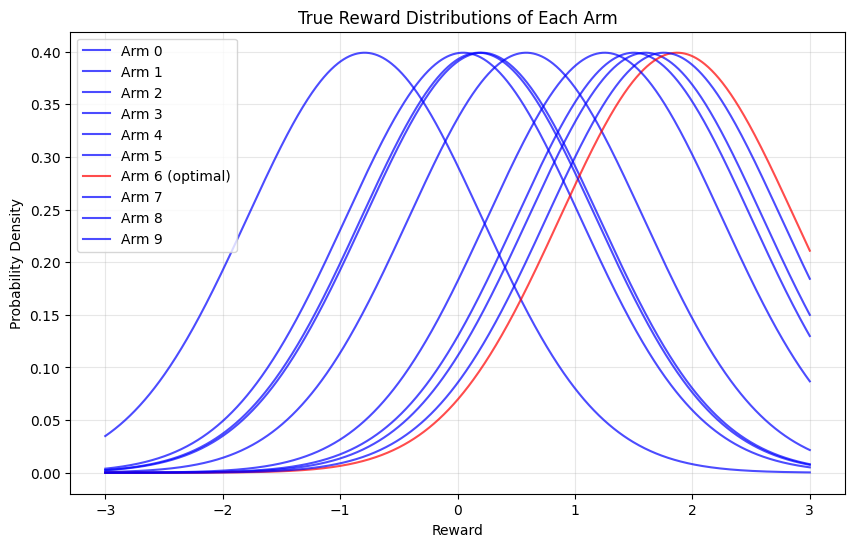

Running experiment with 100 runs of 1000 steps each...


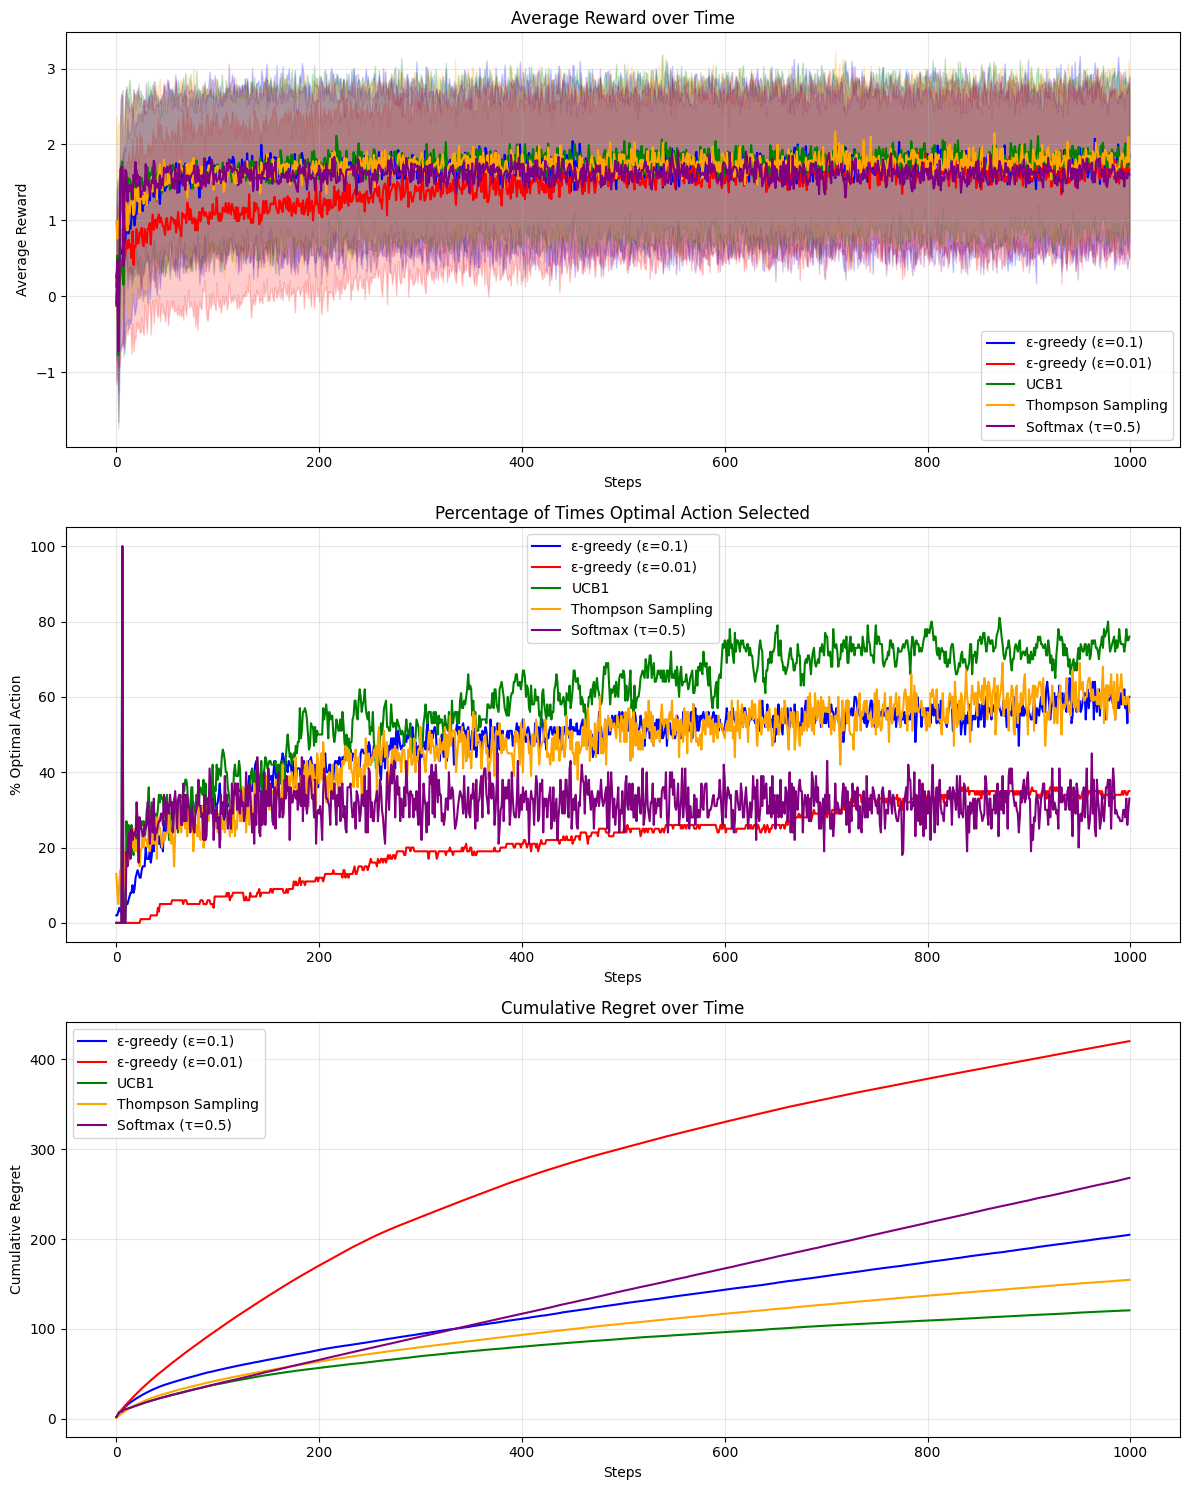


Final Statistics:
ε-greedy (ε=0.1):
  Average reward (last 100 steps): 1.717
  Optimal action % (last 100 steps): 58.6%
  Total regret: 204.7

ε-greedy (ε=0.01):
  Average reward (last 100 steps): 1.656
  Optimal action % (last 100 steps): 34.4%
  Total regret: 420.1

UCB1:
  Average reward (last 100 steps): 1.829
  Optimal action % (last 100 steps): 72.9%
  Total regret: 120.6

Thompson Sampling:
  Average reward (last 100 steps): 1.786
  Optimal action % (last 100 steps): 59.7%
  Total regret: 154.6

Softmax (τ=0.5):
  Average reward (last 100 steps): 1.619
  Optimal action % (last 100 steps): 31.1%
  Total regret: 267.9



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

class Bandit:
    """Multi-armed bandit with normally distributed rewards"""
    def __init__(self, k_arms=10, mean_range=(-1, 1), std=1.0):
        self.k_arms = k_arms
        self.true_means = np.random.uniform(mean_range[0], mean_range[1], k_arms)
        self.std = std
        self.optimal_arm = np.argmax(self.true_means)

    def pull(self, arm):
        """Pull an arm and get a reward"""
        return np.random.normal(self.true_means[arm], self.std)

class BanditAlgorithm(ABC):
    """Abstract base class for bandit algorithms"""
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.reset()

    def reset(self):
        self.counts = np.zeros(self.n_arms)
        self.values = np.zeros(self.n_arms)
        self.total_reward = 0
        self.t = 0

    @abstractmethod
    def select_arm(self):
        pass

    def update(self, arm, reward):
        self.t += 1
        self.counts[arm] += 1
        self.total_reward += reward

        # Update running average
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[arm] = new_value

class EpsilonGreedy(BanditAlgorithm):
    """Epsilon-greedy algorithm"""
    def __init__(self, n_arms, epsilon=0.1):
        super().__init__(n_arms)
        self.epsilon = epsilon

    def select_arm(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_arms)
        else:
            return np.argmax(self.values)

class UCB1(BanditAlgorithm):
    """Upper Confidence Bound algorithm"""
    def select_arm(self):
        if self.t < self.n_arms:
            return self.t

        ucb_values = self.values + np.sqrt(2 * np.log(self.t) / self.counts)
        return np.argmax(ucb_values)

class ThompsonSampling(BanditAlgorithm):
    """Thompson Sampling algorithm (Beta distribution for Bernoulli bandits)"""
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.alpha = np.ones(n_arms)
        self.beta = np.ones(n_arms)

    def reset(self):
        super().reset()
        self.alpha = np.ones(self.n_arms)
        self.beta = np.ones(self.n_arms)

    def select_arm(self):
        samples = [np.random.beta(self.alpha[i], self.beta[i]) for i in range(self.n_arms)]
        return np.argmax(samples)

    def update(self, arm, reward):
        super().update(arm, reward)
        # Convert reward to binary for Beta updates
        if reward > 0:
            self.alpha[arm] += 1
        else:
            self.beta[arm] += 1

class Softmax(BanditAlgorithm):
    """Softmax action selection"""
    def __init__(self, n_arms, temperature=1.0):
        super().__init__(n_arms)
        self.temperature = temperature

    def select_arm(self):
        if self.t < self.n_arms and np.any(self.counts == 0):
            return np.argmin(self.counts)

        exp_values = np.exp(self.values / self.temperature)
        probabilities = exp_values / np.sum(exp_values)
        return np.random.choice(self.n_arms, p=probabilities)

def run_experiment(bandit, algorithms, n_steps=1000, n_runs=100):
    """Run experiment comparing different algorithms"""
    results = {alg_name: {
        'rewards': np.zeros((n_runs, n_steps)),
        'optimal_actions': np.zeros((n_runs, n_steps)),
        'regret': np.zeros((n_runs, n_steps))
    } for alg_name in algorithms.keys()}

    for run in range(n_runs):
        # Reset all algorithms
        for alg in algorithms.values():
            alg.reset()

        for t in range(n_steps):
            for alg_name, alg in algorithms.items():
                arm = alg.select_arm()
                reward = bandit.pull(arm)
                alg.update(arm, reward)

                results[alg_name]['rewards'][run, t] = reward
                results[alg_name]['optimal_actions'][run, t] = int(arm == bandit.optimal_arm)

                # Calculate regret (difference from optimal expected reward)
                optimal_reward = bandit.true_means[bandit.optimal_arm]
                expected_reward = bandit.true_means[arm]
                results[alg_name]['regret'][run, t] = optimal_reward - expected_reward

    return results

def plot_results(results, n_steps):
    """Plot the experimental results"""
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))

    colors = ['blue', 'red', 'green', 'orange', 'purple']

    # Average reward plot
    for i, (alg_name, data) in enumerate(results.items()):
        mean_rewards = np.mean(data['rewards'], axis=0)
        std_rewards = np.std(data['rewards'], axis=0)
        axes[0].plot(mean_rewards, label=alg_name, color=colors[i % len(colors)])
        axes[0].fill_between(range(n_steps),
                            mean_rewards - std_rewards,
                            mean_rewards + std_rewards,
                            alpha=0.2, color=colors[i % len(colors)])

    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Average Reward')
    axes[0].set_title('Average Reward over Time')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Optimal action percentage plot
    for i, (alg_name, data) in enumerate(results.items()):
        mean_optimal = np.mean(data['optimal_actions'], axis=0) * 100
        axes[1].plot(mean_optimal, label=alg_name, color=colors[i % len(colors)])

    axes[1].set_xlabel('Steps')
    axes[1].set_ylabel('% Optimal Action')
    axes[1].set_title('Percentage of Times Optimal Action Selected')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Cumulative regret plot
    for i, (alg_name, data) in enumerate(results.items()):
        cumulative_regret = np.cumsum(np.mean(data['regret'], axis=0))
        axes[2].plot(cumulative_regret, label=alg_name, color=colors[i % len(colors)])

    axes[2].set_xlabel('Steps')
    axes[2].set_ylabel('Cumulative Regret')
    axes[2].set_title('Cumulative Regret over Time')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

def plot_arm_distributions(bandit):
    """Visualize the true reward distributions of each arm"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    x = np.linspace(-3, 3, 1000)
    for i in range(bandit.k_arms):
        y = 1/(bandit.std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - bandit.true_means[i])/bandit.std)**2)
        color = 'red' if i == bandit.optimal_arm else 'blue'
        label = f'Arm {i} (optimal)' if i == bandit.optimal_arm else f'Arm {i}'
        ax.plot(x, y, label=label, color=color, alpha=0.7)

    ax.set_xlabel('Reward')
    ax.set_ylabel('Probability Density')
    ax.set_title('True Reward Distributions of Each Arm')
    ax.legend()
    ax.grid(True, alpha=0.3)

    return fig

# Example usage
if __name__ == "__main__":
    # Create a bandit problem
    k_arms = 10
    bandit = Bandit(k_arms=k_arms, mean_range=(-1, 2), std=1.0)

    # Visualize arm distributions
    fig_arms = plot_arm_distributions(bandit)
    plt.show()

    # Initialize algorithms
    algorithms = {
        'ε-greedy (ε=0.1)': EpsilonGreedy(k_arms, epsilon=0.1),
        'ε-greedy (ε=0.01)': EpsilonGreedy(k_arms, epsilon=0.01),
        'UCB1': UCB1(k_arms),
        'Thompson Sampling': ThompsonSampling(k_arms),
        'Softmax (τ=0.5)': Softmax(k_arms, temperature=0.5)
    }

    # Run experiment
    n_steps = 1000
    n_runs = 100
    print(f"Running experiment with {n_runs} runs of {n_steps} steps each...")
    results = run_experiment(bandit, algorithms, n_steps=n_steps, n_runs=n_runs)

    # Plot results
    fig_results = plot_results(results, n_steps)
    plt.show()

    # Print final statistics
    print("\nFinal Statistics:")
    for alg_name, data in results.items():
        avg_reward = np.mean(data['rewards'][:, -100:])  # Average of last 100 steps
        optimal_percentage = np.mean(data['optimal_actions'][:, -100:]) * 100
        total_regret = np.sum(np.mean(data['regret'], axis=0))

        print(f"{alg_name}:")
        print(f"  Average reward (last 100 steps): {avg_reward:.3f}")
        print(f"  Optimal action % (last 100 steps): {optimal_percentage:.1f}%")
        print(f"  Total regret: {total_regret:.1f}")
        print()